# Training of Recurrenct Neural Network (RNN) model on spectrograms

In [1]:
import numpy as np
import pandas as pd

from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt

from PIL import Image
import matplotlib
import random

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers


tf.config.run_functions_eagerly

<function tensorflow.python.eager.polymorphic_function.polymorphic_function.run_functions_eagerly(run_eagerly)>

In [3]:
# Loading of datasets

spectr_train_list = pd.read_csv("spectr_train_list.txt", index_col = 0).iloc[:,0].values.tolist()
spectr_test_list = pd.read_csv("spectr_test_list.txt", index_col = 0).iloc[:,0].values.tolist()

# labels_train, labels_test
# spectrograms_train, spectrograms_test

# perm1 = np.random.permutation(len(spectr_train_list))
# perm2 = np.random.permutation(len(spectr_test_list))

# # print(int(perm1))

# spectr_train_list = spectr_train_list[perm1]
# spectr_test_list = spectr_test_list[perm2]

np.random.seed(44)

np.random.shuffle(spectr_train_list)
np.random.shuffle(spectr_test_list)


labels_train = []
spectrograms_train = []

for path in spectr_train_list:
    labels_train.append(path.split("/")[1])
    
    
    rgb = matplotlib.image.imread(path)
    gray = np.mean(rgb, -1)
    spectrogram = (255*(gray - np.min(gray))/np.ptp(gray)).astype(int)  # [0, 255] scaled

    spectrograms_train.append(spectrogram)

labels_test = []
spectrograms_test = []

for path in spectr_test_list:
    labels_test.append(path.split("/")[1])
    
    rgb = matplotlib.image.imread(path)
    gray = np.mean(rgb, -1)
    spectrogram = (255*(gray - np.min(gray))/np.ptp(gray)).astype(int)  # [0, 255] scaled
    
    spectrograms_test.append(spectrogram)


In [24]:
labels_test[0:9]

['up', 'yes', 'off', 'down', 'stop', 'off', 'down', 'stop', 'go']

In [26]:
len(spectr_train_list)

18538

In [27]:
len(spectr_test_list)

2577

In [4]:
# preparing datasets for models

dummies = pd.get_dummies(labels_train)
y_train = tf.one_hot(dummies,10)

dataset_train = tf.data.Dataset.from_tensor_slices((spectrograms_train, dummies)).shuffle(200).batch(8)

####################

dummies2 = pd.get_dummies(labels_test)
y_test = tf.one_hot(dummies2, 10)

dataset_test = tf.data.Dataset.from_tensor_slices((spectrograms_test, dummies2)).batch(8)

#####################

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                           mode='max',
                           verbose=1,
                           patience=4)


# Model architecture

In [5]:
# model - LSTM
def get_model_RNN():
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.LSTM(units = 128, return_sequences = True, input_shape=[64,64]))
  model.add(tf.keras.layers.LSTM(units = 128, return_sequences = True))

  model.add(tf.keras.layers.Dense(units = 64))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units = 10, activation='softmax'))

  model.compile(loss = 'categorical_crossentropy',
             optimizer = keras.optimizers.Adam(learning_rate = 0.001),
             metrics = ['accuracy'])
  return model

In [6]:
# RNN model training

model_RNN = get_model_RNN()

model_RNN.fit(dataset_train, epochs=15,  callbacks =[early_stop], validation_data=dataset_test)

Epoch 1/15
2318/2318 [==============================] - 205s 86ms/step - loss: 1.1346 - accuracy: 0.6024 - val_loss: 0.9198 - val_accuracy: 0.6794
Epoch 2/15
2318/2318 [==============================] - 217s 94ms/step - loss: 0.7882 - accuracy: 0.7246 - val_loss: 0.8893 - val_accuracy: 0.6981
Epoch 3/15
2318/2318 [==============================] - 220s 95ms/step - loss: 0.6842 - accuracy: 0.7619 - val_loss: 0.8801 - val_accuracy: 0.7004
Epoch 4/15
2318/2318 [==============================] - 221s 95ms/step - loss: 0.6069 - accuracy: 0.7874 - val_loss: 0.7722 - val_accuracy: 0.7433
Epoch 5/15
2318/2318 [==============================] - 231s 100ms/step - loss: 0.5465 - accuracy: 0.8084 - val_loss: 0.8242 - val_accuracy: 0.7429
Epoch 6/15
2318/2318 [==============================] - 229s 99ms/step - loss: 0.4840 - accuracy: 0.8305 - val_loss: 0.8276 - val_accuracy: 0.7421
Epoch 7/15
2318/2318 [==============================] - 228s 99ms/step - loss: 0.4337 - accuracy: 0.8454 - val_loss: 

In [7]:
model_RNN.save('./model_final_RNN.h5',save_format='h5')
model = tf.keras.models.load_model('./model_final_RNN.h5')

# Conclusions - RNN model

The RNN (standard) model obtained **74.41\% accuracy** on validation data set.

Reminder: it was a 10 class classification problem with balanced classes.


# Evaluation of the best model - confusion matrix

In [8]:
aux = model.predict(dataset_test)

321/321 [==============================] - 10s 26ms/step


In [9]:
aux = np.argmax(aux, axis = 1)

In [10]:
NumbersToWordsMap = {9: "yes", 3:"no",8:"up",0:"down",2:"left",6:"right",
                     5:"on",4:"off",7:"stop",1:"go"}

In [11]:
predicted_labels = np.vectorize(NumbersToWordsMap.get)(aux)

predicted_labels

array(['up', 'stop', 'right', ..., 'on', 'up', 'off'], dtype='<U5')

In [12]:
true_labels = np.array(labels_test)
true_labels

array(['stop', 'stop', 'right', ..., 'on', 'up', 'off'], dtype='<U5')

In [13]:
y_test[440,0,0]

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [14]:
from sklearn.metrics import confusion_matrix

In [15]:
cf_matrix = confusion_matrix(true_labels, predicted_labels)
print(cf_matrix)

[[179  19   6  26   2   7   0   7   5   2]
 [ 18 172   5  23   4   5   3   9   8   4]
 [  1   7 191   5   8   3  12   7  15  18]
 [ 28  42   7 149   2   3   5   9   5   2]
 [  0   4   4   2 157  33   2  11  47   2]
 [  3   1   2   0  16 212   6   0   6   0]
 [  3   5  23   3   3   8 210   1   2   1]
 [  2   9   6   8   8   1   3 182  29   1]
 [  1   1   3   5  14   3   5  12 227   1]
 [  2   7  25   6   5   2   6   3   1 199]]


[Text(0.5, 1.0, 'Confusion matrix with frequency predictions - validation data'),
 Text(50.722222222222214, 0.5, 'Predicted value of label'),
 Text(0.5, 23.52222222222222, 'True value of label')]

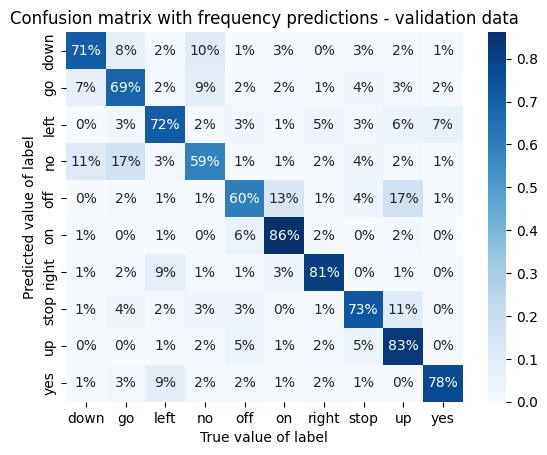

In [16]:
import seaborn as sns

#ticklabels = ["yes","no","up","down","left","right","on","off","stop","go"]

#sth = {9: "yes", 3:"no",8:"up",0:"down",2:"left",6:"right", 5:"on",4:"off",7:"stop",1:"go"}

ticklabels = ["down", "go", "left", "no", "off", "on", "right", "stop", "up", "yes"]

sns.heatmap(cf_matrix/np.sum(cf_matrix, axis = 1), annot=True, fmt='.0%', cmap='Blues', xticklabels=ticklabels, yticklabels=ticklabels).set(title = "Confusion matrix with frequency predictions - validation data", ylabel = "Predicted value of label", xlabel = "True value of label")





# Conclusions - confusion matrix

The most mistaken labels ( one with another) were **go** and **no** - it is understandable, because even a human can sometimes mishear these words and thus confuse them.

The model predicted **on**, **right** and **up** labels with the highest success - reaching almost 90\%.